## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora).

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam.

## Setup

###Check GPU

In [9]:
!nvidia-smi

Fri Jun 21 10:11:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   69C    P0              32W /  72W |   7751MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

###Install required libraries
SDXL’s UNet is three times larger and includes a second text encoder, making it potentially very demanding on computational resources. It might not run efficiently on consumer GPUs like the Tesla T4. To manage this larger model and accelerate training, consider enabling **gradient checkpointing**, **mixed precision**, and **gradient accumulation steps**. Additionally, you can further reduce memory usage by activating **memory-efficient attention** with xFormers and utilizing the **8-bit optimizer** from bitsandbytes.

Accelerate provides a unified interface for launching and training across various distributed setups, enabling you to concentrate on your PyTorch training code without worrying about adapting it to different environments. This facilitates easy scaling of your PyTorch code for training and inference on hardware like GPUs and TPUs. Additionally, Accelerate offers Big Model Inference, which simplifies loading and running inference with large models that typically don't fit in memory.

In [2]:
!pip install bitsandbytes transformers accelerate peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.9 MB/s eta 0:00:00


Make sure to install `diffusers` from `main`.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Initialize `accelerate`:

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [ ]:
!pip install datasets -q

###Download training scripts
Download diffusers SDXL DreamBooth&LoRa training script and SDXL LoRa training script.

In [1]:
!wget https://raw.githubusercontent.com/nuwandda/sdxl-lora-training/main/train_dreambooth_lora_sdxl.py
!wget https://raw.githubusercontent.com/nuwandda/sdxl-lora-training/main/train_text_to_image_lora_sdxl.py

--2024-06-21 12:29:44--  https://raw.githubusercontent.com/nuwandda/sdxl-lora-training/main/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84303 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.002s  

2024-06-21 12:29:45 (44.2 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84303/84303]



## Dataset

For this task, we have provided customer data (5-20 images). We need to label them first and then start training.



###Upload provided images
We need to upload images. Change the **local_dir** parameter according to your wish. This path will be your dataset path.

In [7]:
import os
from google.colab import files

# Pick a name for the image folder
local_dir = "./data/" #@param
os.makedirs(local_dir)
os.chdir(local_dir)

# Choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

Saving 1.png to 1.png
Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 4.png to 4.png
Saving 5.png to 5.png
Saving 6.png to 6.png
Saving 7.png to 7.png


###Preview the upload images

In [28]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

Update **dataset_path** with where you uploaded the provided images first.

Update **image_extension** according to the extension of the uploaded images.

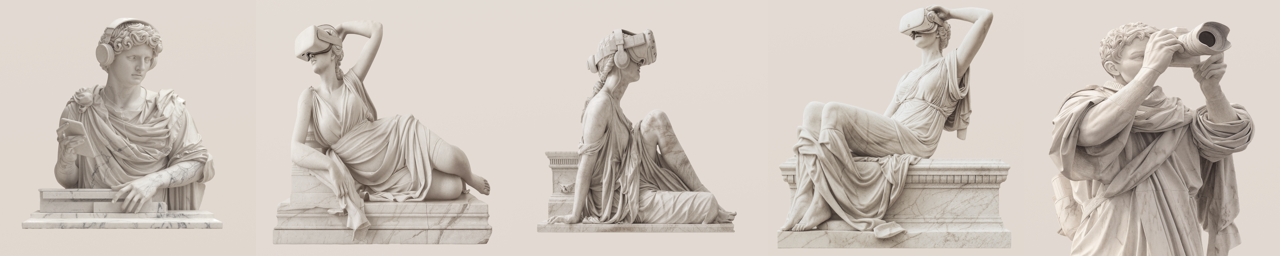

In [8]:
import glob

# Change path to display images from your dataset path
dataset_path = "./data/" #@param
image_extension = "png" #@param
img_paths = dataset_path + "*." + image_extension
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with Claude/ChatGPT-4
We will send the images to the API and receive annotations. First, we need to download the annotation script.

In [ ]:
!wget https://raw.githubusercontent.com/nuwandda/sdxl-lora-training/main/annotate_data.py

Now, we need to run the annotation script. This script requires OpenAI API key to run. You need to get your API key from this [link](https://platform.openai.com/api-keys) after creating an account.

After creating an API key, please update the **--images_path** with dataset path, **--image_extension** with the extension of the images in the dataset and **--secret_key** with your API key.

The last argument is responsible about the identifier. You can add additional identifiers that can help steer the model in the right direction. For example, if we want to train a model about marble statues, we can use statue as argument. For this training, we have sample images about marble statues. So, we will use **--focus "statue"**

This script will generate a file named **metadata.jsonl**. This will be our annotation file for the training.

In [ ]:
!pip install openai

In [ ]:
!python annotate_data.py --images_path "data" --image_extension "png" --secret_key "your_API_key" --focus "statue"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

##Training

#### Set Hyperparameters
To ensure we can DreamBooth with LoRA or only LoRa on a heavy pipeline like Stable Diffusion XL, we will use:

* Gradient checkpointing (`--gradient_checkpointing`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training

 You can choose one of them to train your LoRa. The one with Dreambooth is the better option to generate desired images.

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.
 - Change `--instance_prompt` according to your main object in the dataset. We will use **statue** in this example.
 - Update `--dataset_name` according to your path.
 - Change `--validation_prompt` according to the captions of your dataset.

###Dreambooth&LoRa Training

In [11]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="data" \
  --output_dir="statue_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a photo of CUS statue" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-06-21 09:12:43.965933: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 09:12:44.019352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-2

###LoRa Training

In [ ]:
!accelerate launch train_text_to_image_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="data" \
  --output_dir="statue_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --validation_prompt="A statue of a man wearing a virtual reality headset" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

## Inference
After training our LoRa, we can test it. Just update trained LoRa path and load the model for testing. If you get an error in the cell below after training, please restart session and start from the cell below.

In [2]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights("/content/statue_LoRA/pytorch_lora_weights.safetensors", weight_name="pytorch_lora_weights.safetensors")
_ = pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.w

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In the cell below, we only need to update **dataset_focus** according to our main object. Then, use any prompt you want to generate in **input_prompt**.

###Inference for Dreambooth&LoRa

  0%|          | 0/25 [00:00<?, ?it/s]

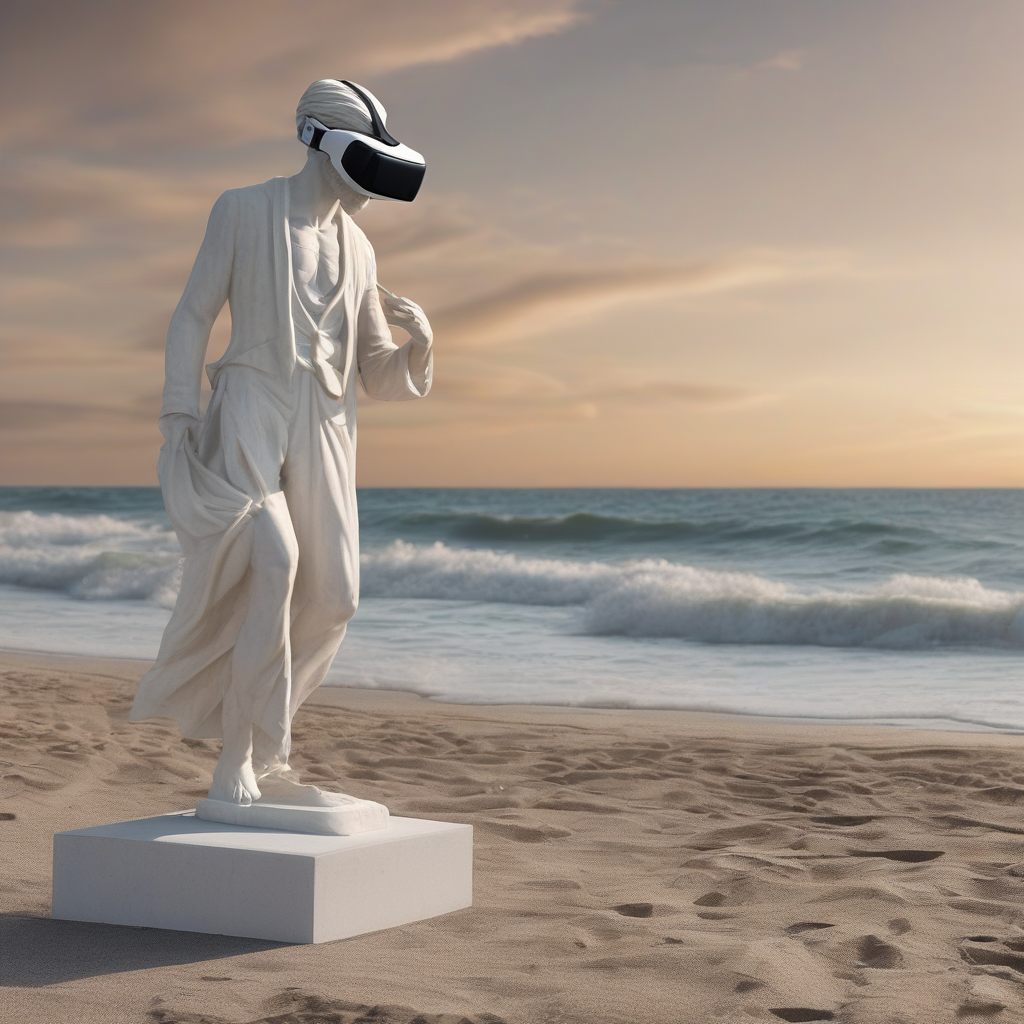

In [6]:
dataset_focus = "statue" #@param
prompt_prefix = "a photo of CUS " + dataset_focus + ", "
input_prompt = "a marble statue of a man at the beach wearing a virtual reality headset" # @param

prompt = prompt_prefix + input_prompt
image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

###Inference for only LoRa

In [ ]:
prompt = "a marble statue of a man at the beach wearing a virtual reality headset" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image